## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
# ! pip install spacy

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
# baseline tokenizer
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

# other tokenizer
spacy_en = spacy.load('en_core_web_sm')
def tokenize_src(text):
    return WordPunctTokenizer().tokenize(text.lower())[::-1]
    #return WordPunctTokenizer().tokenize(text.lower())

def tokenize_trg(text):
    #return [tok.text for tok in spacy_en.tokenizer(text)]
    return WordPunctTokenizer().tokenize(text.lower())

In [5]:
SRC = Field(tokenize=tokenize_src,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_trg,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9279
Unique tokens in target (en) vocabulary: 6769


Here are tokens from original (RU) corpus:

In [8]:
SRC.vocab.itos[::1000]

['<unk>',
 'проходят',
 'downtown',
 'ин',
 'guesthouse',
 'художественной',
 'ju',
 'фуншала',
 'джунглей',
 'султан']

And from target (EN) corpus:

In [9]:
TRG.vocab.itos[::1000]

['<unk>', 'packed', 'catania', 'canton', 'maris', 'slovenska', 'macba']

And here is example from train dataset:

In [24]:
print(vars(train_data.examples[11]))

{'trg': ['they', 'are', 'all', 'equipped', 'with', 'a', 'fan', ',', 'while', 'the', 'kitchen', 'comes', 'with', 'a', 'fridge', 'and', 'stove', '.'], 'src': ['.', 'плитой', 'и', 'холодильником', 'оснащена', 'кухня', '.', 'вентилятором', 'воспользоваться', 'могут', 'гости']}


Let's check the length distributions:

Length distribution in Train data


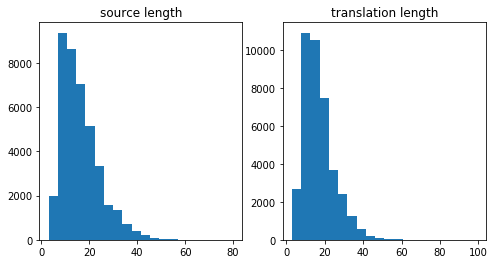

In [11]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


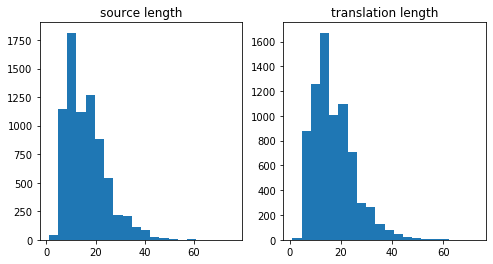

In [12]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [14]:
from utils import *
from routine import train_model


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

BATCH_SIZE = 128

PAD_IDX = TRG.vocab.stoi['<pad>']

In [29]:
def _len_sort_key(x):
    return len(x.src)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 58x128]
	[.src]:[torch.LongTensor of size 60x128]
torch.Size([60, 128]) torch.Size([58, 128])


#### Baseline model

In [16]:
import nmt_lstm

encoder = nmt_lstm.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = nmt_lstm.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_baseline = nmt_lstm.Seq2Seq(encoder, decoder, device).to(device)
model_baseline.apply(init_weights)

print(f'The model has {count_parameters(model_baseline):,} trainable parameters')

optimizer = optim.Adam(model_baseline.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

The model has 14,937,201 trainable parameters


In [17]:
import nmt_lstmAttention

encoder_att = nmt_lstmAttention.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder_att = nmt_lstmAttention.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_att = nmt_lstmAttention.Seq2Seq(encoder_att, decoder_att, device).to(device)
model_att.apply(init_weights)

print(f'The model has {count_parameters(model_att):,} trainable parameters')

optimizer_att = optim.Adam(model_att.parameters(), lr=1e-3)
scheduler_att = ReduceLROnPlateau(optimizer_att, mode='min', factor=0.3, patience=2)
criterion_att = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

The model has 15,723,633 trainable parameters


In [18]:
#import nmt_cnnlstm

#Encoder_cnn = nmt_cnnlstm.Encoder
#Decoder_cnn = nmt_cnnlstm.Decoder
#Seq2Seq_cnn = nmt_cnnlstm.Seq2Seq

#enc_cnn = Encoder_cnn(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
#dec_cnn = Decoder_cnn(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
#model_cnn = Seq2Seq_cnn(enc_cnn, dec_cnn, device).to(device)

#model_cnn.apply(init_weights)
#print(f'The model has {count_parameters(model_cnn):,} trainable parameters')

#PAD_IDX = TRG.vocab.stoi['<pad>']
#optimizer_cnn = optim.Adam(model_cnn.parameters())
#criterion_cnn = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [19]:
#model = train_model(model, {"train":train_iterator,"valid":valid_iterator}, optimizer, criterion, scheduler, n_epochs=20,  clip=1, show_plots=True, nameModel="nmt_lstm.pth")
if device==torch.device('cuda'):
    torch.cuda.empty_cache()

In [20]:
model_att = train_model(model_att, {"train":train_iterator,"valid":valid_iterator}, optimizer_att, criterion_att,scheduler_att, n_epochs=15,  clip=1, show_plots=True, nameModel="nmt_lstmAttention.pth")
if device==torch.device('cuda'):
    torch.cuda.empty_cache()

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,    4,    4,  ...,    4,    4,    4],
        [ 194, 1302, 9007,  ...,  265,  487,    0],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
torch.Size([42, 128])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


KeyboardInterrupt: 

In [ ]:
#model_cnn = train_model(model_cnn, {"train":train_iterator,"valid":valid_iterator}, optimizer_cnn, criterion_cnn, n_epochs=2,  clip=1, show_plots=True, nameModel="nmt_cnnlstm.pth")
if device==torch.device('cuda'):
    torch.cuda.empty_cache()

__Let's take a look at our network quality__:

#### load model 1

In [ ]:
with open("4.548559629917145loss_nmt_lstm.pth_epoch11.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")

# because of rand split:train/valid/test, the different len(SRC.vocab)/len(TRG.vocab) obtain
INPUT_DIM = best_state_dict["encoder.embedding.weight"].shape[0]
OUTPUT_DIM = best_state_dict["decoder.out.weight"].shape[0]

Encoder = nmt_lstm.Encoder
Decoder = nmt_lstm.Decoder
Seq2Seq = nmt_lstm.Seq2Seq
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_load1 = Seq2Seq(enc, dec, device).to(device)

model_load1.load_state_dict(best_state_dict) 

#### load model 2 (attention)

In [ ]:
with open("4.506073224544525loss_nmt_lstmAttention.pth_epoch13.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")

# because of rand split:train/valid/test, the different len(SRC.vocab)/len(TRG.vocab) obtain
INPUT_DIM = best_state_dict["encoder.embedding.weight"].shape[0]
OUTPUT_DIM = best_state_dict["decoder.out.weight"].shape[0]

Encoder = nmt_lstmAttention.Encoder
Decoder = nmt_lstmAttention.Decoder
Seq2Seq = nmt_lstmAttention.Seq2Seq
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_load2 = Seq2Seq(enc, dec, device).to(device)

model_load2.load_state_dict(best_state_dict) 

In [ ]:
models = {"load model1":model_load1,"load model2":model_load2,"baseline model": model,"attention model": model_att}

In [ ]:
#del utils

#import utils
#import imp
#imp.reload(utils)
#generate_translation = utils.generate_translation
#remove_tech_tokens = utils.remove_tech_tokens
#get_text = utils.get_text
#flatten = utils.flatten

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

for name in models:
    #test translate
    print("MODEL:{}\nEXAMPLE TRANSLATE:\n".format(name))
    batch = next(iter(test_iterator))
    for idx in [1,2]:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        print(generate_translation(src, trg, models[name], TRG.vocab))
        
    original_text = []
    generated_text = []
    models[name].eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = models[name](src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    print(corpus_bleu([[text] for text in original_text], generated_text) * 100)

In [ ]:
#corpus_bleu([[text] for text in original_text], generated_text) * 100

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points